# Multi-resolution deconvolution of spatial transcriptomics

In this tutorial, we through the steps of applying DestVI for deconvolution of 10x Visium spatial transcriptomics profiles using an accompanying single-cell RNA sequencing data. 

Plan for this tutorial:

1. Loading the data
2. Training the scLVM to learn a basis of gene expression on the scRNA-seq data
3. Training the stLVM to perform the deconvolution
4. Visualize the learned cell type proportions
5. Dig into the intra cell type information 

In [1]:
%%capture
import sys

#if True, will install via pypi, else will install from source
stable = False
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

Let's download our data from a comparative study of murine lymph nodes, comparing wild-type with a stimulation after injection of a mycobacteria. We have at disposal a 10x Visium dataset as well as a matching scRNA-seq dataset from the same tissue.

In [2]:
!wget --quiet https://github.com/romain-lopez/DestVI-reproducibility/blob/master/lymph_node/deconvolution/ST-LN-compressed.h5ad?raw=true -O ST-LN-compressed.h5ad
!wget --quiet https://github.com/romain-lopez/DestVI-reproducibility/blob/master/lymph_node/deconvolution/scRNA-LN-compressed.h5ad?raw=true -O scRNA-LN-compressed.h5ad

In [3]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

from scvi.model import CondSCVI, DestVI

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Data processing

First, let's load the single-cell data

In [4]:
sc_adata = sc.read_h5ad("scRNA-LN-compressed.h5ad")

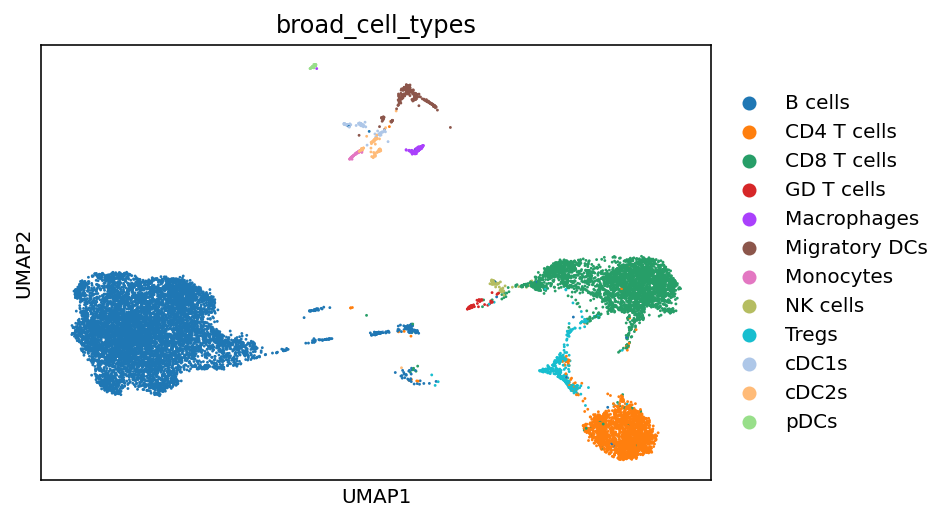

In [5]:
sc.pl.umap(sc_adata, color="broad_cell_types")

In [6]:
# let us filter some genes
G = 2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=G,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

Now, let's load the spatial data and choose a common gene subset

In [7]:
st_adata = sc.read_h5ad("ST-LN-compressed.h5ad")

In [8]:
st_adata.layers["counts"] = st_adata.X.copy()

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)
st_adata.raw = st_adata

In [9]:
# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

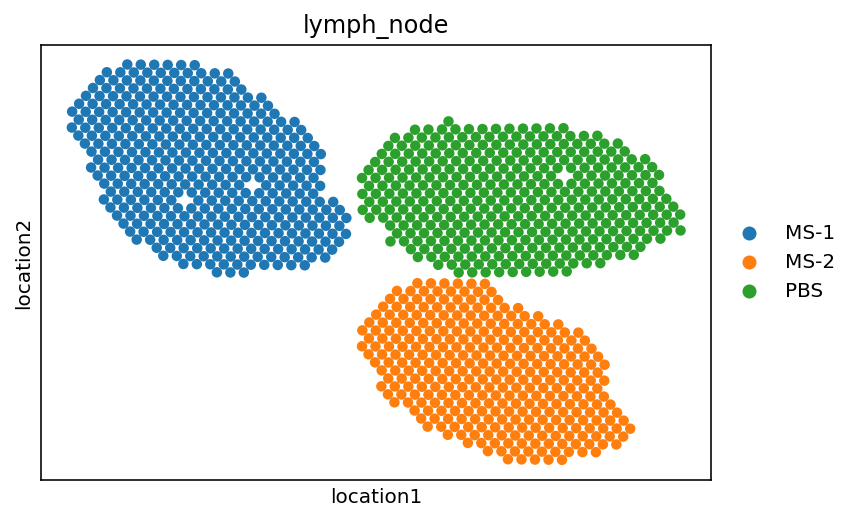

In [10]:
sc.pl.embedding(st_adata, basis="location", color="lymph_node")

## Fit the scLVM

In [11]:
CondSCVI.setup_anndata(sc_adata, layer="counts", labels_key="broad_cell_types")

Here we would like to reweight each measurement by a scalar factor (e.g., the inverse proportion) in the loss of the model so that lowly abundant cell types get better fit by the model.

In [12]:
sc_model = CondSCVI(sc_adata, weight_obs=True)
sc_model.view_anndata_setup()

Anndata setup with scvi-tools version 0.15.0b0.

Setup via `CondSCVI.setup_anndata` with arguments:

{'labels_key': 'broad_cell_types', 'layer': 'counts'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 14989 │
│      n_vars      │ 1888  │
│     n_labels     │  12   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                         labels State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['broad_cell_types'] │    B cells    │          0          │
│                               │  CD4 T cells  │          1          │
│                               │  CD8 T cells  │          2          │
│                               │  GD T cells   │          3          │
│                               │  Macrophages  │          4          │
│                               │ Migratory DCs │          5          │
│                               │   Monocytes   │          6          │
│                               │   NK cells    │          7          │
│                               │     Tregs     │          8          │
│                               │     cDC1s     │          9          │
│                               │     cDC2s     │         10          │
│                               │     pDCs      │         11          │
└───────────────────────────────┴───────────────┴─────────────────────┘

In [13]:
sc_model.train(max_epochs=250)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 1/250:   0%|          | 0/250 [00:00<?, ?it/s]

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:97: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/eecs/jjhong922/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1645690191318/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 250/250: 100%|██████████| 250/250 [06:18<00:00,  1.52s/it, loss=6.33e+03, v_num=1]


<AxesSubplot:xlabel='epoch'>

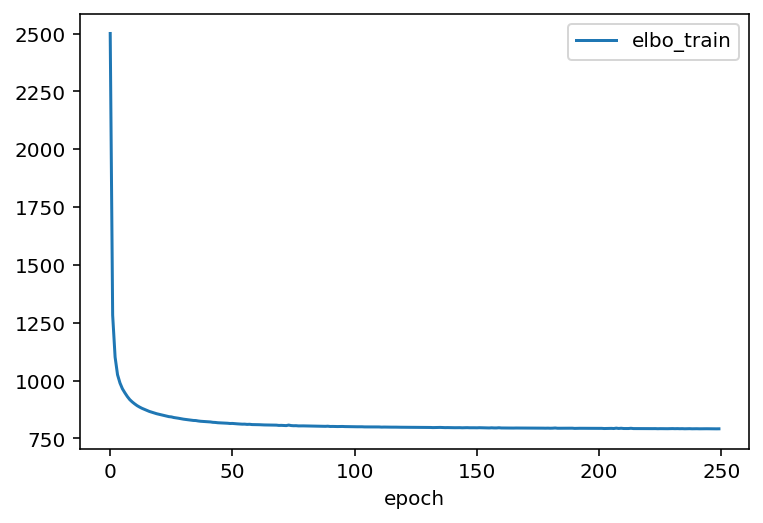

In [ ]:
sc_model.history["elbo_train"].plot()

## Deconvolution with stLVM

In [ ]:
DestVI.setup_anndata(st_adata, layer="counts")

In [ ]:
st_model = DestVI.from_rna_model(st_adata, sc_model)
st_model.view_anndata_setup()

Anndata setup with scvi-tools version 0.15.0b0.

Setup via `DestVI.setup_anndata` with arguments:

{'layer': 'counts'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 1092  │
│      n_vars      │ 1888  │
└──────────────────┴───────┘

              Data Registry              
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃  scvi-tools Location   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │ adata.layers['counts'] │
│    ind_x     │ adata.obs['_indices']  │
└──────────────┴────────────────────────┘

In [ ]:
st_model.train(max_epochs=2500)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 2500/2500: 100%|██████████| 2500/2500 [06:09<00:00,  6.77it/s, loss=1.92e+06, v_num=1]


<AxesSubplot:xlabel='epoch'>

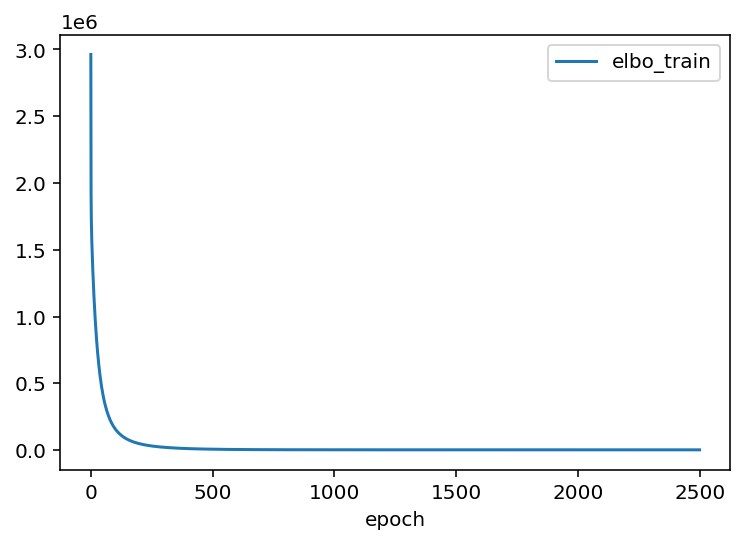

In [ ]:
st_model.history["elbo_train"].plot()

The output of DestVI has two resolution. At the broader resolution, DestVI returns the cell type proportion in every spot. At the more granular resolution, DestVI can impute cell type specific gene expression in every spot. 

## Cell type proportions


In [ ]:
st_adata.obsm["proportions"] = st_model.get_proportions()

In [ ]:
st_adata.obsm["proportions"]

,B cells,CD4 T cells,CD8 T cells,GD T cells,Macrophages,Migratory DCs,Monocytes,NK cells,Tregs,cDC1s,cDC2s,pDCs
AAACCGGGTAGGTACC-1-0,0.554737,0.002882,0.067105,0.001557,0.094520,0.027084,0.015887,0.001132,0.059403,0.132248,0.002019,0.041427
AAACCTCATGAAGTTG-1-0,0.522657,0.107116,0.019725,0.008663,0.002582,0.092361,0.012738,0.000326,0.064761,0.128399,0.003652,0.037021
AAAGACTGGGCGCTTT-1-0,0.432614,0.012946,0.078896,0.000929,0.001115,0.187585,0.000820,0.022425,0.083032,0.126278,0.007756,0.045605
AAAGGGCAGCTTGAAT-1-0,0.023069,0.108239,0.255839,0.014951,0.080744,0.220636,0.014034,0.035769,0.112698,0.091698,0.041177,0.001146
AAAGTCGACCCTCAGT-1-0,0.933701,0.030851,0.001105,0.000707,0.002529,0.000475,0.009145,0.000337,0.001795,0.010649,0.005166,0.003538
...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGTCACACTCGTAA-1-1,0.276420,0.032543,0.217376,0.035088,0.027150,0.125085,0.009592,0.003972,0.057554,0.165867,0.031399,0.017954
TTGTAAGGCCAGTTGG-1-1,0.258355,0.034743,0.043012,0.062984,0.078443,0.248522,0.022277,0.044405,0.045389,0.002430,0.109672,0.049767
TTGTAATCCGTACTCG-1-1,0.502886,0.137160,0.004500,0.001921,0.082069,0.135957,0.000421,0.030085,0.026869,0.045251,0.031028,0.001853
TTGTATCACACAGAAT-1-1,0.184034,0.190209,0.053028,0.038418,0.000765,0.378508,0.034760,0.007423,0.021637,0.076769,0.008887,0.005561


In [ ]:
ct_list = ["B cells", "CD8 T cells", "Monocytes"]
for ct in ct_list:
  data = st_adata.obsm["proportions"][ct].values
  st_adata.obs[ct] = np.clip(data, 0, np.quantile(data, 0.99))

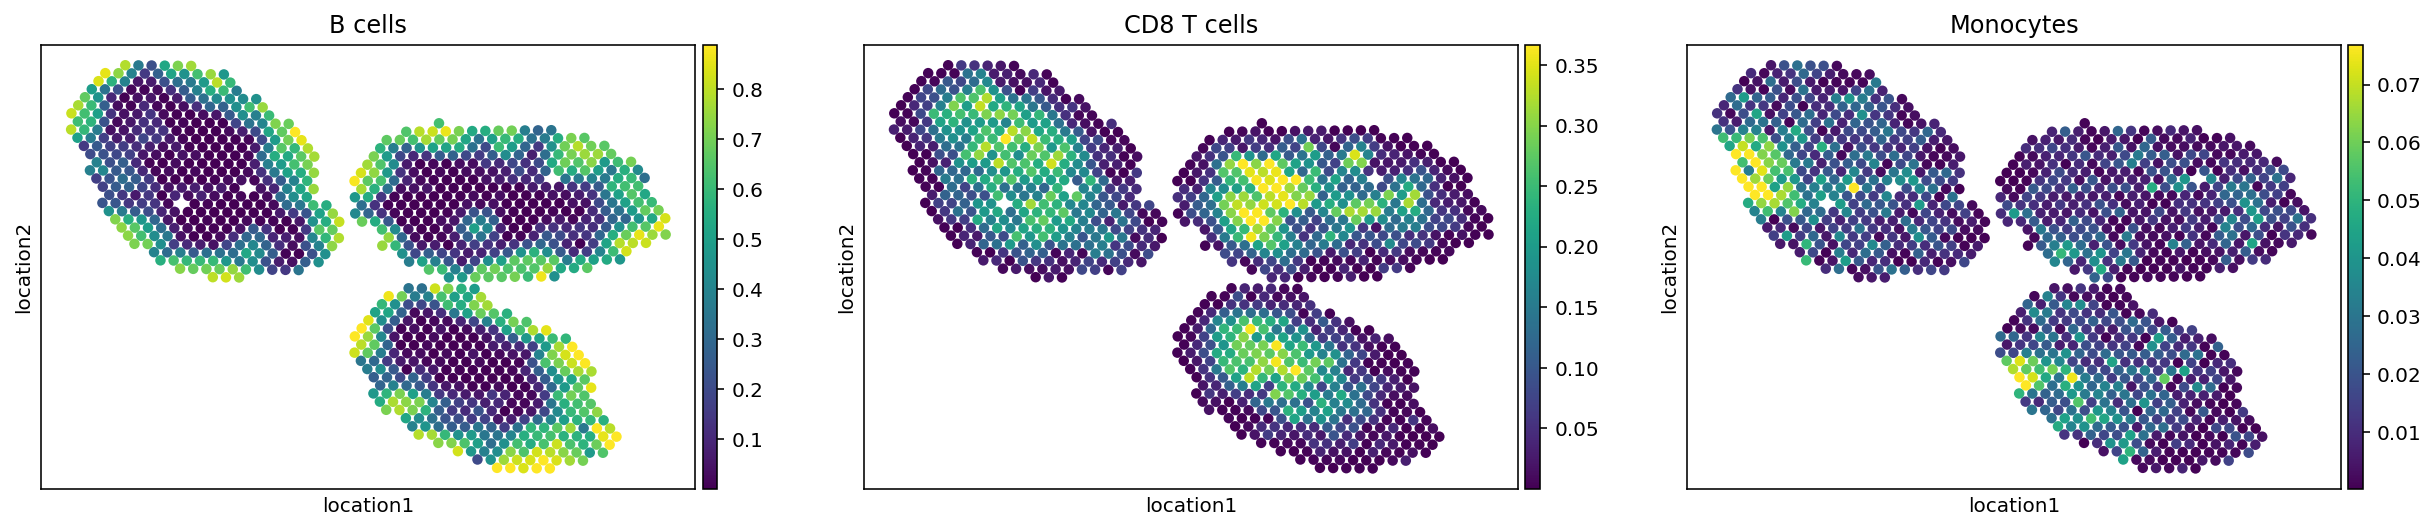

In [ ]:
sc.pl.embedding(st_adata, basis="location", color=ct_list)

We observe a strong compartimentalization of the cell types in the lymph node (B cells / T cells), as expected. We also observe a differential localization of the monocytes (refer to the paper for further details).

## Intra cell type information

At the heart of DestVI is a multitude of latent variables (5 per cell type per spots). We refer to them as "gamma", and we may manually examine them for downstream analysis

In [ ]:
# more globally, the values of the gamma are all summarized in this dictionary of data frames
for ct, g in st_model.get_gamma().items():
  st_adata.obsm["{}_gamma".format(ct)] = g

In [ ]:
st_adata.obsm["B cells_gamma"].head(5)

,0,1,2,3,4
AAACCGGGTAGGTACC-1-0,-0.245641,0.901995,0.738847,-0.005684,1.037822
AAACCTCATGAAGTTG-1-0,-0.290794,1.018534,0.709194,-0.213629,1.334999
AAAGACTGGGCGCTTT-1-0,-0.286885,1.154569,0.525483,-0.175921,1.337471
AAAGGGCAGCTTGAAT-1-0,1.065611,0.235131,-0.111399,-0.426569,1.135491
AAAGTCGACCCTCAGT-1-0,-0.003950,-0.126140,0.410517,-0.624149,0.939917


Because those values may be hard to examine for end-users, we presented several methods for prioritizing the study of different cell types (based on PCA and Hotspot). If you'd like to use those methods, please refer to our DestVI reproducibility repository. If you have suggestions to improve those, and would like to see them in the main codebase, reach out to us. 

In this tutorial, we assume that the user have identified key gene modules that vary within one cell type in the single-cell RNA sequencing data (e.g., using [Hotspot](https://github.com/YosefLab/Hotspot)). We provide here a code snippet for imputing the spatial pattern of the cell type specific gene expression, using the example of the IFN-I inflammation signal.

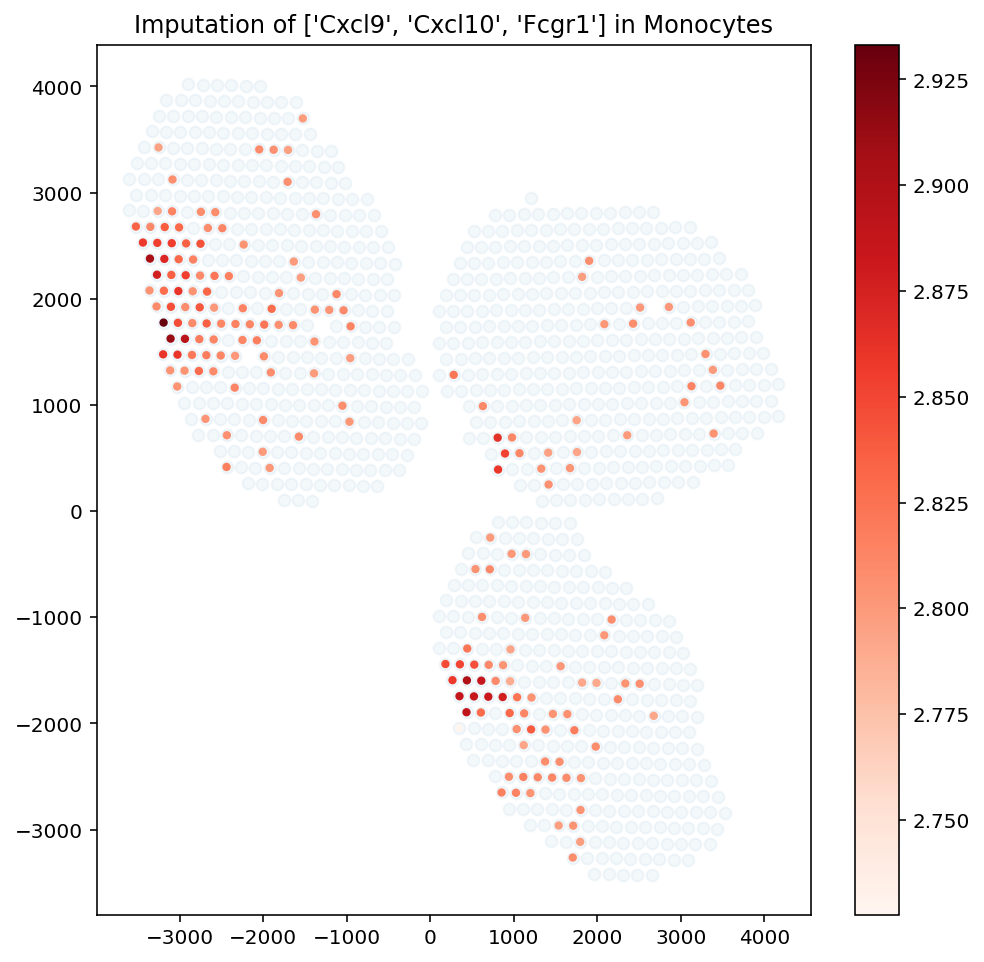

In [ ]:
plt.figure(figsize=(8, 8))

ct_name = "Monocytes"
gene_name = ["Cxcl9", "Cxcl10", "Fcgr1"]


# we must filter spots with low abundance (consult the paper for an automatic procedure)
indices = np.where(st_adata.obsm["proportions"][ct_name].values > 0.03)[0]

# impute genes and combine them
specific_expression = np.sum(st_model.get_scale_for_ct(ct_name, indices=indices)[gene_name], 1)
specific_expression = np.log(1 + 1e4 * specific_expression)

# plot (i) background (ii) g
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(st_adata.obsm["location"][indices][:, 0], st_adata.obsm["location"][indices][:, 1], 
            c=specific_expression, s=10, cmap="Reds")
plt.colorbar()
plt.title(f"Imputation of {gene_name} in {ct_name}")
plt.show()